In [1]:
import pandas as pd
import numpy as np
import sys
import os
import pickle
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'


In [2]:
df = pd.read_csv("./dataset/new_bgg_data_after_eda2_new.csv", encoding="utf-8")
df.drop(columns=["Rank", "Id", "Name", "Year", "Users_rated"], inplace=True)
# df.drop(columns=["Time", "Mintime", "Maxtime", "Age", "Minplayers", "Maxplayers", "Nmechanics", "Ndomains", "Ncategory", "Nartist", "Ndesign"], inplace=True)

In [3]:
test_size = 0.2
random_state = 42
target_list = ["Rating", "Complexity"]
unused_feature_list = ["Sug_players", "Sug_age", "Language_dependence", "Own"]


In [4]:
from sklearn.model_selection import train_test_split


def get_Xs_Ys(df, target=target_list, exclude=unused_feature_list, use_val=True):

    assert type(target) == list, "target must be list"
    assert type(exclude) == list, "exclude must be list"

    train, test = train_test_split(
         df,
         test_size=test_size,
         random_state=random_state)
    if use_val:
        train, val = train_test_split(
            train,
            test_size=test_size,
            random_state=random_state)

    def get_y(data): return data[target]
    def get_x(data): return data.drop(columns=target + exclude)

    Ys = {"train": get_y(train),
        "test": get_y(test)}
    Xs = {"train": get_x(train),
        "test": get_x(test)}

    if use_val:
        Ys['val'] = get_y(val)
        Xs['val'] = get_x(val)

    return Xs, Ys, target


Xs, Ys, target_list = get_Xs_Ys(df)


In [5]:
from hyperopt import fmin, tpe, Trials, STATUS_OK, hp
from sklearn.model_selection import cross_val_score


In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


def make_xgb(xgb_args={}):

    xgb_args["n_estimators"] = int(xgb_args["n_estimators"])
    xgb_args["max_depth"] = int(xgb_args["max_depth"])

    return XGBRegressor(random_state=random_state,
                        n_jobs=-1,
                        tree_method='gpu_hist',
                        early_stopping_rounds=10,
                        gpu_id=0,
                        **xgb_args)


def find_best_param_xgb(df, results=False):

    params = {
        "n_estimators": hp.quniform("n_estimators", 100, 2000, 100),
        "learning_rate": hp.uniform("learning_rate", 0.001, 1.0),
        "max_depth": hp.quniform("max_depth", 2, 20, 2),
        "min_child_weight": hp.uniform("min_child_weight", 0., 2.),
        "gamma": hp.uniform("gamma", 0.0, 1.),
        "subsample": hp.uniform("subsample", 0.5, 1.),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.),
        "lambda": hp.uniform("lambda", 0.1, 10.),
        "alpha": hp.uniform("alpha", 0., 10.),
    }
    Xs, Ys, target_list = get_Xs_Ys(df, use_val=True)

    best_params = []
    trials = []

    i = 0

    def fit_and_eval(params):

        xgb = make_xgb(xgb_args=params)

        xgb.fit(Xs['train'], Ys['train'].iloc[:, i], verbose=False,
                eval_set=[(Xs['train'], Ys['train'].iloc[:, i]), (Xs['val'], Ys['val'].iloc[:, i])])

        y_pred_val = xgb.predict(Xs['val'])

        score = mean_squared_error(Ys['val'].iloc[:, i], y_pred_val)

        return {"loss": score, "status": STATUS_OK}

    for j in range(len(target_list)):

        i = j

        trial = (Trials())

        best_param = fmin(
            fn=fit_and_eval,
            trials=trial,
            space=params,
            algo=tpe.suggest,
            max_evals=10
        )
        best_params.append(best_param)
        trials.append(trial)

    if results:
        return best_params, trials


In [7]:
best_params, trials = find_best_param_xgb(df, results=True)


100%|██████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: 0.2240986993067175]


In [8]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def eval_models(y_pred, y_true, verbose=False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if verbose:

        return {"MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2}
    else:
        return mse, rmse, mae, r2


def test_eval(x_test, y_test, model, target_list):

    assert len(model) == len(target_list)

    eval_tests = []
    for i in range(len(target_list)):

        eval_test = eval_models(model[i].predict(
            x_test), y_test[target_list[i]])
        eval_tests.append(eval_test)

    return pd.DataFrame(eval_tests, index=target_list, columns=["MSE", "RMSE", "MAE", "R2"])


In [9]:
def make_best_model(params, Xs, Ys, target_list):

    assert len(params) == len(target_list)

    models = []

    for i, param in tqdm(enumerate(params)):
        xgb = make_xgb(xgb_args=param)
        xgb.fit(Xs['train'], Ys['train'][target_list[i]], verbose=False,
                eval_set=[(Xs['train'], Ys['train'][target_list[i]]),
                          (Xs['val'], Ys['val'][target_list[i]])])

        models.append(xgb)

    return models


In [10]:
xgbs = make_best_model(best_params, Xs, Ys, target_list)


0it [00:00, ?it/s]

In [11]:
test_eval(Xs['test'], Ys['test'], xgbs, target_list)

,MSE,RMSE,MAE,R2
Rating,0.473540,0.688143,0.521406,0.446660
Complexity,0.222833,0.472052,0.335643,0.681984


In [12]:
import eli5
from eli5.sklearn import PermutationImportance


In [13]:
def perm_imp(model, x_val, y_val, results=False):
    permuter = PermutationImportance(
        model,
        scoring="r2",
        n_iter=10,
        random_state=random_state)

    permuter.fit(x_val, y_val)

    feature_names = x_val.columns.tolist()
    pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()

    pi.tail(20).plot.barh()
    plt.rcParams['font.family'] = 'Malgun Gothic'
    plt.title(f"Permutation Importance Top 20 for {y_val.name} ")
    plt.show()

    if results:
        return pi.tail(20).index


  0%|          | 0/2 [00:00<?, ?it/s]

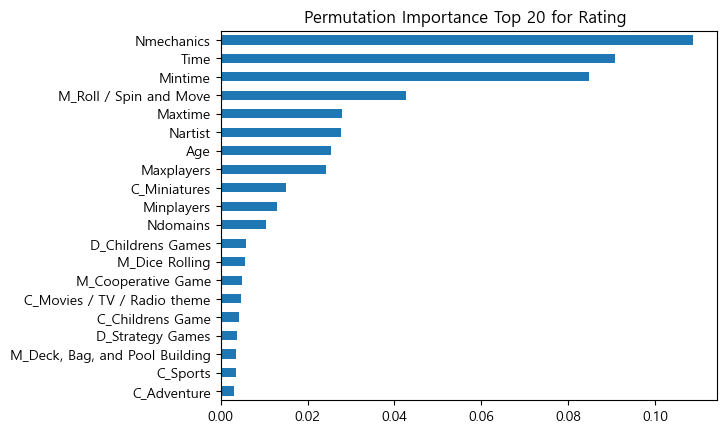

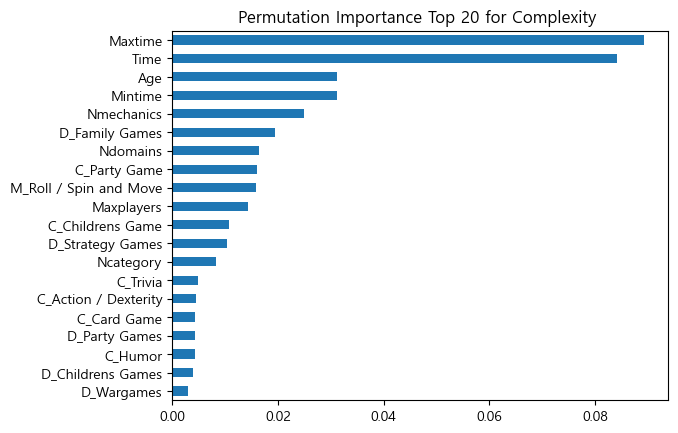

In [14]:
top10_features = []
for i in tqdm(range(len(target_list))):
    features = perm_imp(xgbs[i], Xs['test'], Ys['test'].iloc[:, i], results=True)
    top10_features.append(features)


In [15]:
top10_features = list(map(sorted,top10_features))


Rating ['Age', 'C_Adventure', 'C_Childrens Game', 'C_Miniatures', 'C_Movies / TV / Radio theme', 'C_Sports', 'D_Childrens Games', 'D_Strategy Games', 'M_Cooperative Game', 'M_Deck, Bag, and Pool Building']


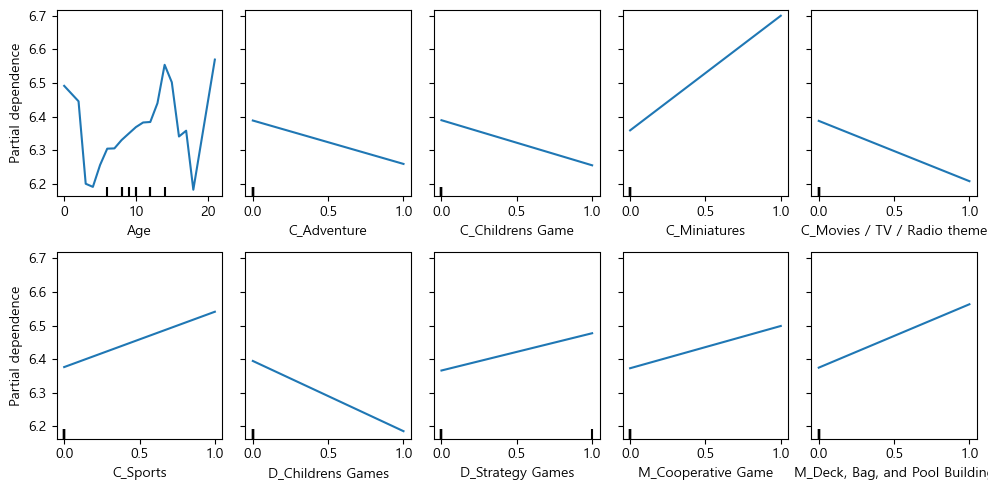

Rating ['M_Dice Rolling', 'M_Roll / Spin and Move', 'Maxplayers', 'Maxtime', 'Minplayers', 'Mintime', 'Nartist', 'Ndomains', 'Nmechanics', 'Time']


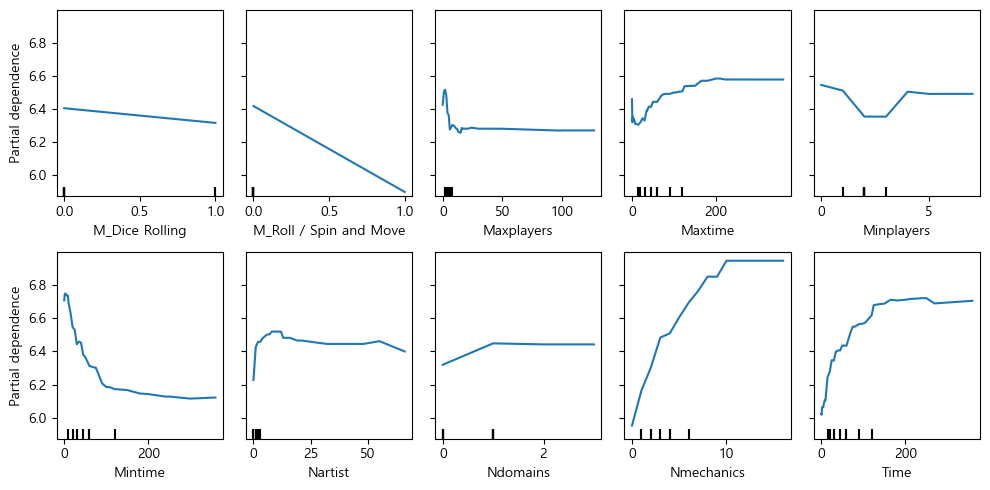

Complexity ['Age', 'C_Action / Dexterity', 'C_Card Game', 'C_Childrens Game', 'C_Humor', 'C_Party Game', 'C_Trivia', 'D_Childrens Games', 'D_Family Games', 'D_Party Games']


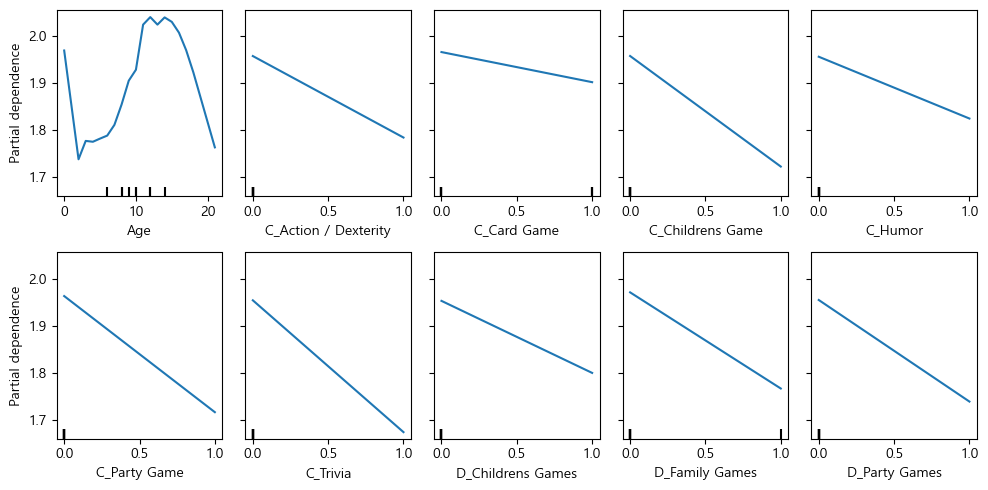

Complexity ['D_Strategy Games', 'D_Wargames', 'M_Roll / Spin and Move', 'Maxplayers', 'Maxtime', 'Mintime', 'Ncategory', 'Ndomains', 'Nmechanics', 'Time']


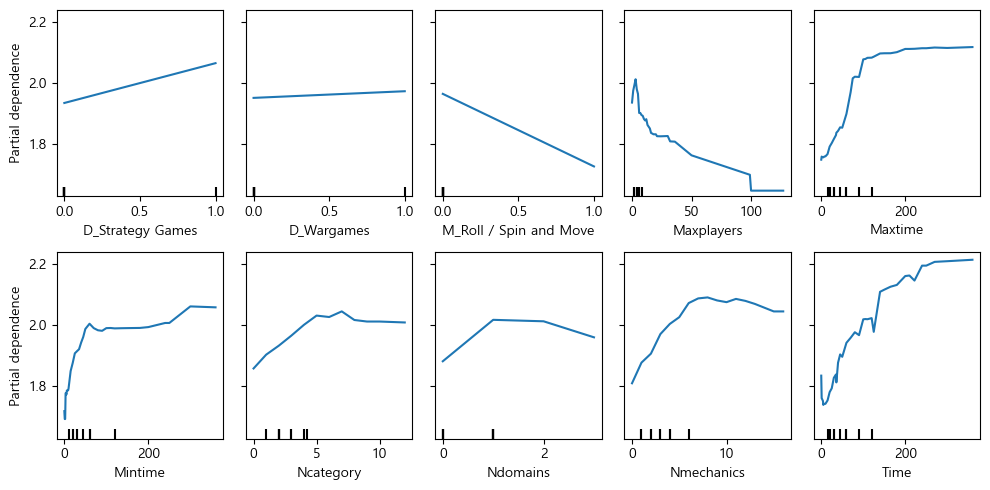

In [19]:
from sklearn.inspection import PartialDependenceDisplay

for i, features in enumerate(top10_features):
    for j in range(len(features)//10):
        print(target_list[i], features[j*10:j*10+10])
        fig, ax= plt.subplots(2, 5, figsize=(10, 5))
        PartialDependenceDisplay.from_estimator(
            xgbs[i], Xs['val'], features[j*10:j*10+10], ax=ax, n_cols=5)
        fig.tight_layout()
        plt.show()